# Anomaly Detection Based on Copulas (COPOD)

A python-based, fast, parameter-free, and highly interpretable unsupervised anomaly detection method.
Anomaly detection is (usually) an unsupervised learning task where the objective is to identify suspicious observations in data. The task is constrained by the cost of incorrectly flagging normal points as anomalous and failing to flag actual anomalous points.

**Copula-Based Outlier Detection — COPOD — is a new algorithm for anomaly detection. It has been implemented in the PyOD python package.**
It has several key features that make it stand out from competing algorithms:
* Deterministic
* No hyperparameters! (This is important because is difficult to tune hyperparameters for outlier detection tasks because the true labels are rare, unknown, or difficult to obtain)
* Top-performance on benchmark anomaly detection datasets
* Interpretable and easy to visualize anomalies
* Fast and computationally efficient
* Scales to high-dimensional datasets

The biggest challenge of COPOD is the complex mathematics behind the algorithm. This article contains two sections:
    
1. Summary of the key concepts of copulas and description of the COPOD algorithm.
2. Tutorial of COPOD in python, showing how you can easily detect anomalies in data with this method.

## Copula Models for Anomaly Detection
#### Copulas defined
What is a copula?
Simply stated, a copula describes the dependence structure between random variables.

#### Outlier scores
Interpretation: A higher anomaly score indicates that there is a low probability of the data instance because it lies on the tail of the data distribution.
Outlier scores lie between (0, ∞) and are directly comparable. They do not directly indicate outlier probability. Instead, they measure the likelihood of a row, relative to other points in the dataset.
To get outlier predictions from COPOD, there are two options:

1. Set a threshold on the outlier scores; any row with a score that exceeds the threshold is an anomaly
2. Select to top-k or top-kth-percentile outlier scores.

Here, I use the generate_data function from PyOD to generate a synthetic dataset with 200 training samples and 100 test samples. The normal samples are generated by a multivariate Gaussian distribution; the outlier samples are generated using a uniform distribution.
Both train and test datasets have 5 features and 10% of rows are labeled as anomalies. I add a bit of random noise to the data to make it slightly harder to perfectly separate normal and outlier points.

In [1]:
import pandas as pd

In [2]:
from pyod.utils.data import generate_data
import numpy as np
X_train, y_train, X_test, y_test = generate_data(n_train=200,
                      n_test=100,
                      n_features=5,
                      contamination=0.1,
                      random_state=3) 
X_train = X_train * np.random.uniform(0, 1, size=X_train.shape)
X_test = X_test * np.random.uniform(0,1, size=X_test.shape)

C:\ProgramData\Anaconda3\lib\site-packages\pyod\utils\data.py:186: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.9.0. Please use behaviour="new", which makes the returned datasets in the order of X_train, X_test, y_train, y_test.
  warn('behaviour="old" is deprecated and will be removed '


In [3]:
from pyod.models.copod import COPOD
clf_name = 'COPOD'
clf = COPOD()
clf.fit(X_train)
test_scores = clf.decision_function(X_test)

from pyod.utils.utility import precision_n_scores
from sklearn.metrics import roc_auc_score
roc = round(roc_auc_score(y_test, test_scores), ndigits=4)
prn = round(precision_n_scores(y_test, test_scores), ndigits=4)
print(f'{clf_name} ROC:{roc}, precision @ rank n:{prn}')
# >> COPOD ROC:0.9989, precision @ rank n:0.9

COPOD ROC:1.0, precision @ rank n:1.0


In PyOD, a (fitted) outlier detector has two key functions: decision_function and predict.
decision_function returns an anomaly score for each row.

predict returns an array of 0’s and 1’s, indicating whether each row is predicted to be normal (0) or an outlier (1). The predict function simply applies a threshold to the anomaly score returned by the decision_function. The threshold is automatically calibrated based on the specified contamination rate parameter set when initializing the detector (e.g. clf=COPOD(contamination=0.1). The contamination indicates the expected percentage of outliers in the training data.

#### COPOD does not require training data!
In the real world, you might not have labeled training data — that’s okay! You can still use COPOD to detect outliers.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Outlier score')

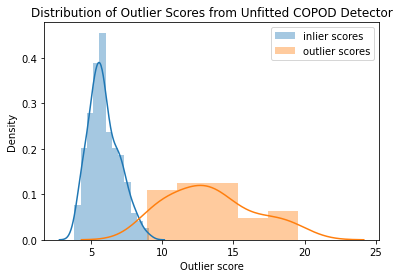

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
X = np.concatenate([X_train, X_test], axis=0)
ys = np.concatenate([y_train, y_test])

detector = COPOD()
scores = detector.decision_function(X)

sns.distplot(scores[ys==0], label="inlier scores")
sns.distplot(scores[ys==1], label="outlier scores").set_title("Distribution of Outlier Scores from Unfitted COPOD Detector")
plt.legend()
plt.xlabel("Outlier score")

As you see in the example above, I initialized the COPOD algorithm and simply passed data through the decision_function without fitting. The outlier scores of outlier points were generally much greater than those for inliers, or normal data points.
In application, it is usually useful to select thresholds for COPOD anomaly scores in order to identify which data to investigate as anomalies.

#### Cool Feature: Anomaly Explanation
COPOD can explain which feature(s) contributed most to the outlier score. This is especially helpful when there are many features in your dataset or you want to tell a human reviewer why the algorithm selected a particular row as an outlier.

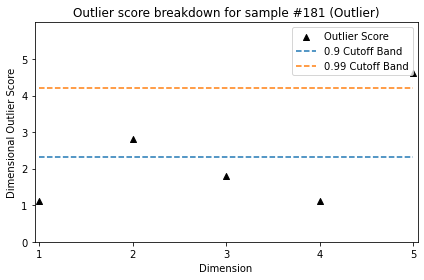

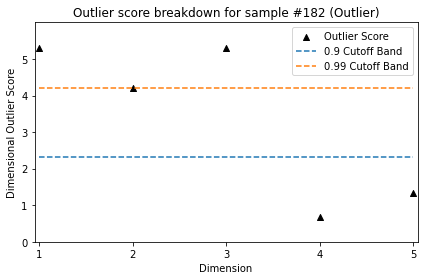

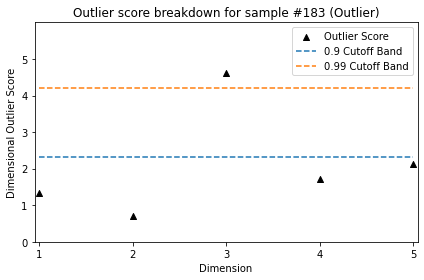

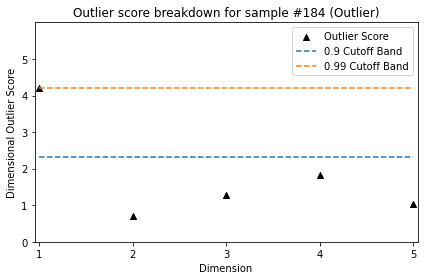

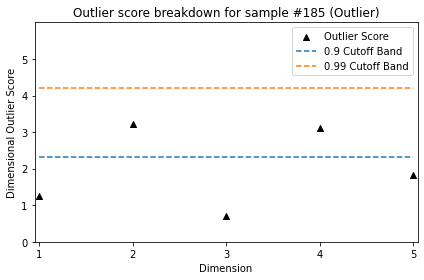

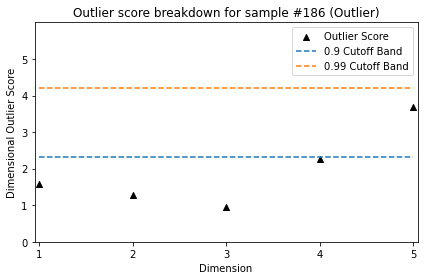

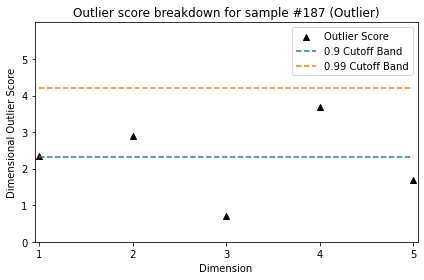

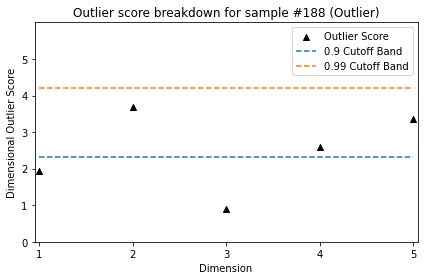

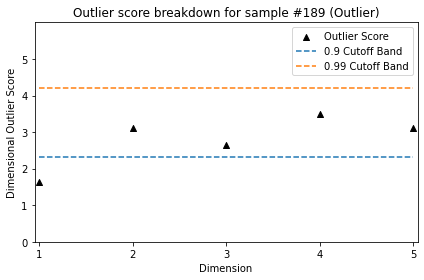

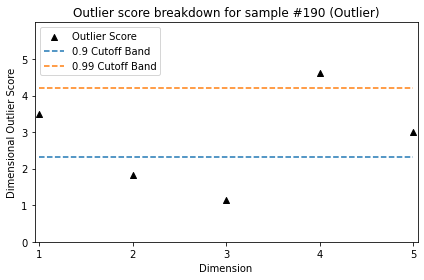

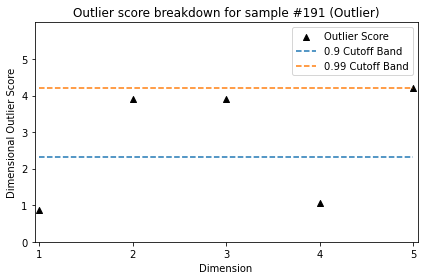

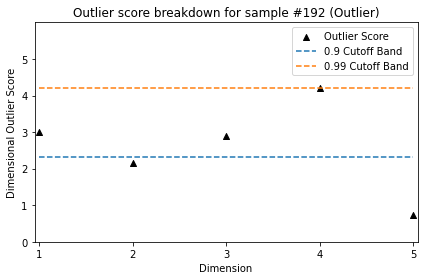

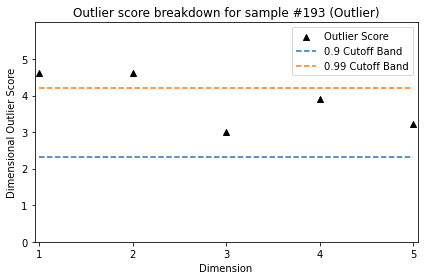

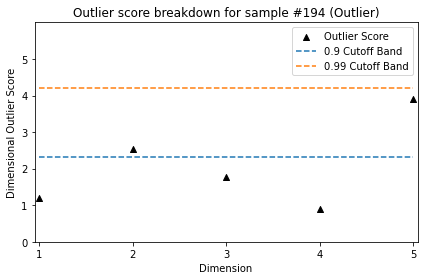

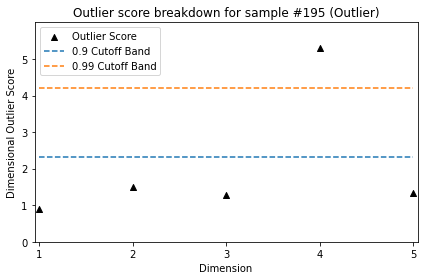

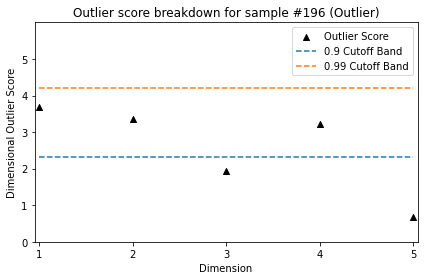

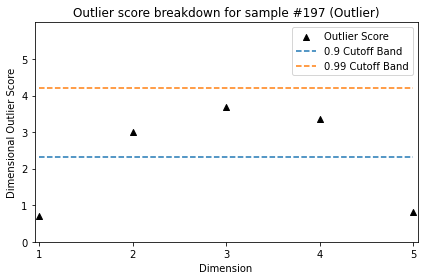

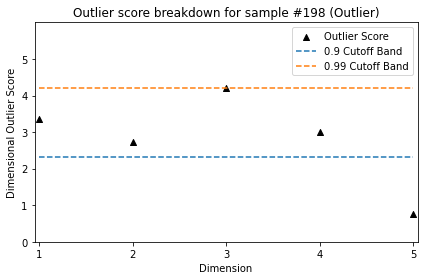

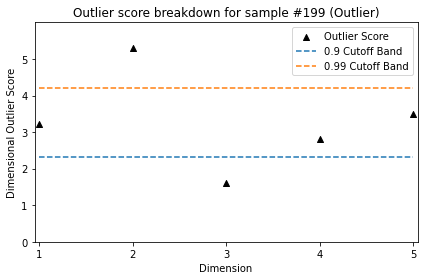

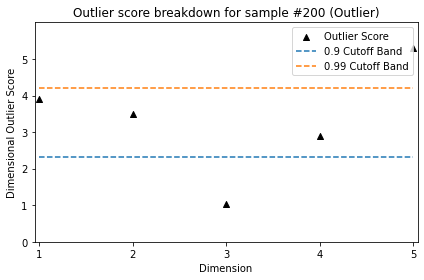

In [6]:
import numpy as np
clf = COPOD()
clf.fit(X_train)

train_outliers_idx = np.where(y_train==1)[0]
for idx in train_outliers_idx:
  clf.explain_outlier(idx, cutoffs=None, feature_names=None)

The two Dimensional Outlier Graphs above plot the feature-level outlier scores for two true outliers (rows) detected as outliers by COPOD with the blue line. The x-axis indicates the feature and the y-axis indicates the outlier score for that feature alone. The 90th and 99th percentile outlier scores are also plotted.

In the left plot (row #182), the outlier score for dimension 3 exceeds the 99th percentile, meaning it is the main reason the row is an outlier.

In the right plot (row #193), the outlier scores for dimensions 1 and 2 both exceed the 99th percentile and are both reasons the row is an outlier.